In [1]:
import sys
sys.path.append("..")
import MDAnalysis as mda
import nglview as nv
import matplotlib.pyplot as plt
import cellbell
import seaborn as sns
import pickle
sns.set()
RANDOM_SEED = 281090

In [2]:
from MDAnalysis.analysis.dihedrals import Ramachandran, Janin

In [3]:
raw_data_dir = '../data/raw'
interim_data_dir = '../data/interim'
processed_data_dir = '../data/processed'
reports_dir = '../reports'

In [ ]:
calculate = False

# Calculate dihedrals

In [5]:
res_list = [ 51, 62, 64, 78, 96, 98, 99, 100, 102, 103, 107, 108, 111 ] 

In [ ]:
if calculate:
    data = {}
    u_open = mda.Universe(f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/3FB5_lb/protein_sk1_pbc.xtc')
    u_fully_open = mda.Universe(f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.pdb',
                f'{interim_data_dir}/5VK6_lb/protein_sk1_pbc.xtc')
    for res_name in res_list:
        print(res_name)
        data[res_name] = {}
        for state_name,u in zip(['o', 'fo'],[u_open, u_fully_open]):
            res = u.select_atoms(f'resid {res_name}')
            data[res_name][state_name]= {}
            data[res_name][state_name]['ramachandran'] = Ramachandran(res).run()
            try: 
                data[res_name][state_name]['janin'] = Janin(res).run()
            except:
                data[res_name][state_name]['janin'] = None
    with open(f'{processed_data_dir}/dihedrals.pkl', 'wb') as handle:
        pickle.dump(data, handle)
else:
    with open(f'{processed_data_dir}/dihedrals.pkl', 'rb') as handle:
        data = pickle.load(handle)

51
62
64
78
96


<AxesSubplot:xlabel='$\\phi$ (deg)', ylabel='$\\psi$ (deg)'>

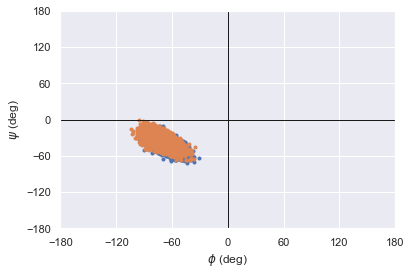

In [18]:
data[111]['fo']['ramachandran'].plot(marker='.')
data[107]['fo']['ramachandran'].plot(marker='.')

<AxesSubplot:>

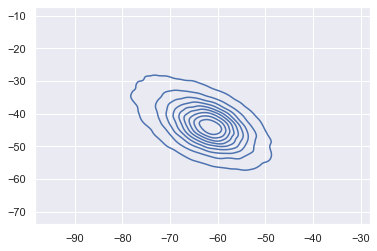

In [29]:
sns.kdeplot(x=a[:,0],y=a[:,1])

In [30]:
res_list = [111]

In [ ]:
fig, ax = plt.subplots(len(res_list), 2)
skip = 100
for i, res_name in enumerate(res_list):
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:skip:,0],y=a[:skip:,1],label='fo')
    a = data[res_name]['fo']['ramachandran']
    a = a.reshape([a.shape[0]*a.shape[1],2])
    sns.kdeplot(x=a[:skip:,0],y=a[:skip:,1],label='o')
#     ax[i,0].set_xlim([-180,180])
#     ax[i,0].set_xlabel(r'$\phi (^{\circ})$')
#     ax[i,0].set_ylabel(r'$\psi (^{\circ})$')
#     ax[i,0].set_ylim([-180,180])
#     ax[i,0].leggend()